<a href="https://colab.research.google.com/github/edwardauron/DS-Unit-2-Sprint-4-Model-Validation/blob/master/Logisitic_Cross_Validation_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q kaggle
!pip install seaborn==0.9.0

In [0]:
!mkdir -p ~/.kaggle

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, brier_score_loss, 
                             precision_score, recall_score, f1_score)


from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import LinearSVC
from yellowbrick.classifier import ROCAUC
from zipfile import ZipFile

In [4]:
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"otillieodd","key":"d170637b759479e1af28bb5ce552ebfd"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d ntnu-testimon/paysim1

paysim1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

'kaggle (1).json'   kaggle.json   PS_20174392719_1491204439457_log.csv
'kaggle (2).json'   paysim1.zip   sample_data


In [8]:
!unzip paysim1.zip

Archive:  paysim1.zip
replace PS_20174392719_1491204439457_log.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [9]:
!ls

'kaggle (1).json'   kaggle.json   PS_20174392719_1491204439457_log.csv
'kaggle (2).json'   paysim1.zip   sample_data


In [10]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Let's label encode our names, and hot encode our types of payment for better processing. We choose not to label encode any numerical values, because they are attached to unique instances of customer interaction. If we had one input for multiple, like a lot, of outputs, label encoding would be a fine choice for numerical consistency.

In [0]:
le = LabelEncoder()
labels = ['nameOrig', 'nameDest']
for label in labels:
  df[label] = le.fit_transform(df[label].values)

In [13]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,PAYMENT,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,TRANSFER,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,CASH_OUT,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [14]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [0]:
df = pd.get_dummies(df, prefix=['type'])

In [16]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,0,1,0


In [17]:
df.step.max()

743

# Something weird
It looks like step goes all the way up to 743, i found some papers handling sequential data, but for now i think im actually going to drop step, because i honestly dont know how to handle it. 

In [0]:
df = df.drop('step', axis=1)

# I do not choose to scale the data. 
It is not required, and Sklearn has some rather robust handling for logistic models.

In [0]:
clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                         fit_intercept=True, intercept_scaling=1,
                         class_weight=None,random_state=42, solver='lbfgs', 
                         max_iter=10000, multi_class='warn', verbose=0, 
                         warm_start=False, n_jobs=None)

In [0]:
y = df['isFraud']
X = df.drop(['isFraud'], axis=1)

# Into the fold

I chose to use cross_val_predict because I wanted to eval my entire dataset. This...might...take awhile.

In [23]:
predicted = cross_val_predict(clf, X, y, cv=4)
print(accuracy_score(y, predicted))

0.9989056395007089


In [24]:
print(classification_report(y, predicted)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.60      0.46      0.52      8213

   micro avg       1.00      1.00      1.00   6362620
   macro avg       0.80      0.73      0.76   6362620
weighted avg       1.00      1.00      1.00   6362620



In [25]:
print ('ROC_AUC', roc_auc_score(y, predicted))

ROC_AUC 0.7307751070524785


# Result

p = True positive / (True Positive + False Positive)
r = True positives / (True Positives + False Negative) 

66 percent of our fraudulents were correct from the total guesses of fraud. Not terrible. But not good.

We were only able to detect fraud 45 percent of the time though. Which is really bad. That means not only do we lack data, but fraud and not-fraud likely have some very similair characteristcs.  



# Looking at exact values


In [0]:
x = confusion_matrix(y, predicted)

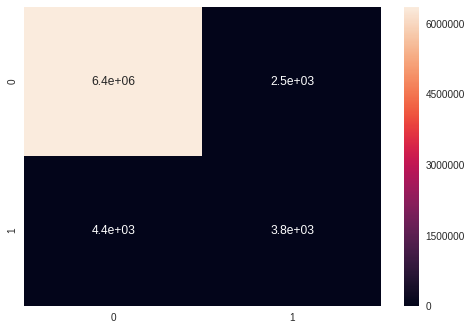

In [27]:
sns.heatmap(x, annot=True)

# ROC_AUC

http://www.scikit-yb.org/en/latest/api/classifier/rocauc.html

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.95)

'ROC curve displays the true positive rate on the Y axis and the false positive rate on the X axis on both a global average and per-class basis. The ideal point is therefore the top-left corner of the plot: false positives are zero and true positives are one.''

In [0]:
roc_auc =  ROCAUC(clf)
roc_auc.fit(X_train, y_train)
show_me = roc_auc.poof()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.9991708149357208

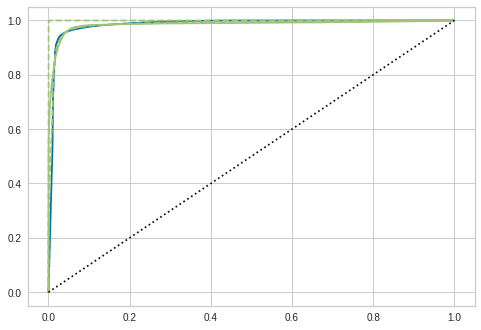

In [30]:
roc_auc.score(X_test, y_test)

# More proof that data is impaired by over saturation of non-fraud

The model fits d$%# near perfectly, but look at the steepness of the area under the curve, it's quite severe. It feels like yay the model is really good at predicting correctly, but it's actually terrible. It's just really good at predicting what is not fraud, because that's what it knows. You know? 


This looks promising : https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

In [0]:
# code taken from Sklearn examples


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [0]:
# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(), "SVC", 2)

plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Logistic:
	Brier: 0.001
	Precision: 0.766
	Recall: 0.454
	F1: 0.570

Naive Bayes:
	Brier: 0.005
	Precision: 0.056
	Recall: 0.188
	F1: 0.086

Naive Bayes + Isotonic:
	Brier: 0.001


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	Precision: 0.000
	Recall: 0.000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	F1: 0.000

Naive Bayes + Sigmoid:
	Brier: 0.001


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	Precision: 0.000
	Recall: 0.000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	F1: 0.000



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Logistic:
	Brier: 0.001
	Precision: 0.766
	Recall: 0.454
	F1: 0.570



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC:
	Brier: 0.938
	Precision: 0.901
	Recall: 0.394
	F1: 0.548



# Counter-measure?

https://imbalanced-learn.org/en/stable/over_sampling.html 


# Class imbalance

Let's visualize it. 

In [0]:
# http://www.scikit-yb.org/en/latest/api/target/class_balance.html
